In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [2]:
# Load historical sales data
df = pd.read_csv('sales_data.csv')  

In [3]:
# Explore the data
print(df.head())
print(df.info())

   Order   File_Type  SKU_number  SoldFlag  SoldCount MarketingType  \
0      2  Historical     1737127       0.0        0.0             D   
1      3  Historical     3255963       0.0        0.0             D   
2      4  Historical      612701       0.0        0.0             D   
3      6  Historical      115883       1.0        1.0             D   
4      7  Historical      863939       1.0        1.0             D   

   ReleaseNumber  New_Release_Flag  StrengthFactor  PriceReg  ReleaseYear  \
0             15                 1        682743.0     44.99         2015   
1              7                 1       1016014.0     24.81         2005   
2              0                 0        340464.0     46.00         2013   
3              4                 1        334011.0    100.00         2006   
4              2                 1       1287938.0    121.95         2010   

   ItemCount  LowUserPrice  LowNetPrice  
0          8         28.97        31.84  
1         39          0.00

In [4]:
# Assuming 'SoldCount' represents the demand or sales count
demand_column = 'SoldCount'

In [5]:
# Fill or drop missing values
df[demand_column].fillna(method='ffill', inplace=True)

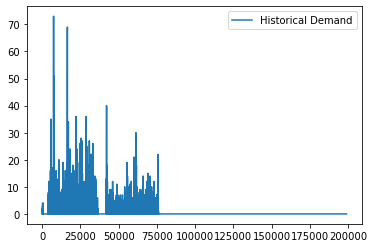

In [6]:
# Plot historical demand
plt.plot(df.index, df[demand_column], label='Historical Demand')
plt.legend()
plt.show()

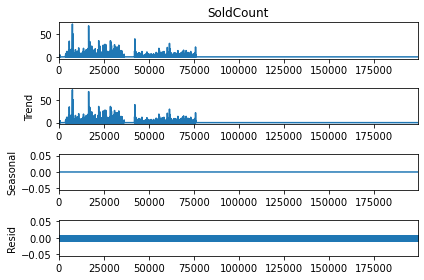

In [7]:
# Decompose time series data to visualize seasonality and trends
result = seasonal_decompose(df[demand_column], model='additive', period=1) 
result.plot()
plt.show()

In [8]:
# Perform Augmented Dickey-Fuller test for stationarity
result_adf = adfuller(df[demand_column])
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])

ADF Statistic: -21.63655507266174
p-value: 0.0


In [9]:
# Check stationarity after differencing
df['Demand_diff'] = df[demand_column].diff().dropna()

# Drop infinite and NaN values
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Check stationarity again
result_adf_diff = adfuller(df['Demand_diff'])
print('ADF Statistic after differencing:', result_adf_diff[0])
print('p-value after differencing:', result_adf_diff[1])

ADF Statistic after differencing: -56.27395363356485
p-value after differencing: 0.0


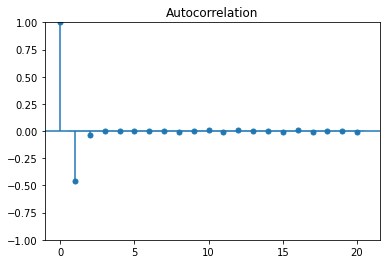

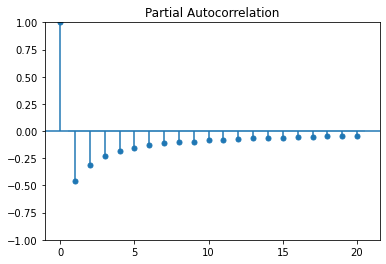

In [10]:
# Plot autocorrelation and partial autocorrelation with specified method
plot_acf(df['Demand_diff'], lags=20)
plot_pacf(df['Demand_diff'], lags=20, method='ywm')  
plt.show()

In [19]:
p, d, q = 1, 1, 1  
P, D, Q, m = 1, 1, 1, 12 
# Define the SARIMA model
order = (p, d, q)  # Order determined from ACF and PACF plots
seasonal_order = (P, D, Q, m)  # Seasonal order determined from ACF and PACF plots
model = SARIMAX(df[demand_column], order=order, seasonal_order=seasonal_order)

In [20]:
# Fit the model
results = model.fit()

In [21]:
# Assuming 'results' is the fitted SARIMA model
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          SoldCount   No. Observations:                75995
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood             -117941.990
Date:                            Thu, 22 Feb 2024   AIC                         235893.979
Time:                                    20:06:11   BIC                         235940.171
Sample:                                         0   HQIC                        235908.172
                                          - 75995                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1070      0.001    126.214      0.000       0.105       0.109
ma.L1         -0.9980      0.000  -

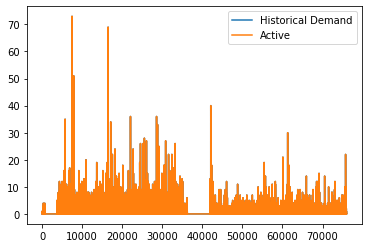

In [22]:
# Plot historical demand and forecast
plt.plot(df.index, df[demand_column], label='Historical Demand')
plt.plot(df.index, df[demand_column], label='Active')
plt.legend()
plt.show()